# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1

# 1. Libraries

In [309]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn import preprocessing
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )

# 2. Import

## 2.1. Set directories

In [5]:
ROOTPATH = os.getcwd()

data_folder = 'Data_definitive'

# Path to the whole database
path_data = os.path.join(ROOTPATH, data_folder)

## 2.2 Importing functions

In [446]:
def get_data(path, daterule):
    '''
    Format a Data frame with Adj Close prices for all tickers (columns) during the concerned date range (index).
    Daterule item filters the number of dates we need
    '''
    list_dataframes = []
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                import_df = pd.read_csv(csvfile, index_col=None, header=0)
                adj_close_arr = import_df['Adj Close'].values
                ticker = file_.split('_')[4]
                
                if len(adj_close_arr) != daterule or np.isnan(adj_close_arr).any() or ticker == 'IBB':
                    # If we don't have the specified number of obs, or some nan: ignore
                    # Also ignore the IBB here. (Imported in Calibration)
                    continue
                    
                list_dataframes = list_dataframes + list(adj_close_arr)
                dates = import_df['Date'].values
                list_tickers.append(ticker)
                i += 1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                import_df = pd.read_csv(csvfile, index_col=None, header=0)
                adj_close_arr = import_df['Adj Close'].values
                ticker = file_.split('_')[4]
                
                if len(adj_close_arr) != daterule or np.isnan(adj_close_arr).any() or ticker == 'IBB':
                    # If we don't have the specified number of obs, or some nan: ignore
                    # Also ignore the IBB here. (Imported in Calibration)
                    continue
                    
                list_dataframes = list_dataframes + list(adj_close_arr)
                dates = import_df['Date'].values
                list_tickers.append(ticker)
                i += 1
    
    num_files = i
    # Reshape our list to an array with the good shape, ready to be fitted in a dataframe
    list_dataframes = np.reshape(list_dataframes, [len(list_tickers), len(dates)]).T
    df_out_adj_close = pd.DataFrame(list_dataframes, index=dates, columns=list_tickers)
    
    return num_files, df_out_adj_close

In [447]:
def normalize_data(df):
    '''
    Use the preprocessing object MinMaxScaler from sklearn library to normalize the data.
    The out dataframe has the same index and column
    '''
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_n = pd.DataFrame(x_scaled, index=df.index, columns=df.columns)
    return df_n

## 2.4 Create the first Dataframes

We are going to create the two first dataframes:
- Dataframes with all Adj Closes
- Dataframe with the normalized data

Structure of the DataFrames:
- Columns: Tickers (x155)
- Rows: Dates (671 days)
We will also extract the list of tickers in the right order, plus the quote dates

In [448]:
num_files, DF_adj_close = get_data(path_data, 671)

In [449]:
# import_tickers is array_type
list_tickers = DF_adj_close.columns
# dates is array-type
dates = DF_adj_close.index.values

Now, we create for each ticker a dataframe of normalized adj close : DF_adj_close_n

In [450]:
DF_adj_close_n = normalize_data(DF_adj_close)

# 3. Encoding Phase

## 3.1. Functions

### 3.1.1. Intialize functions

In [451]:
def weight_variable(num_input, num_output):
    weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
    weight_shape = [num_input, num_output]
    W = tf.get_variable('W', weight_shape, initializer = weight_init)
    return(W)

def bias_variable(num_output):
    bias_init = tf.constant_initializer(value = 0)
    bias_shape = [num_output]
    b = tf.get_variable('b', bias_shape, initializer = bias_init)
    return(b)

### 3.1.2. Layer functions

In [452]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name, bool_drop):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            W = weight_variable(num_input, num_output)
            variable_summary_light(W)
    
        with tf.variable_scope('biases'):
            b = bias_variable(num_output)
            variable_summary_light(W)
            
        
        if bool_drop:
            dropped_or_not = dropout(input_tensor, keep_prob)
        else:
            dropped_or_not = input_tensor
            
        logits = tf.matmul(dropped_or_not, W) + b
            
    return tf.nn.relu(layer_batch_normalization(logits, num_output, phase_train)), W

In [453]:
def encoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_e_1 = layer(input_tensor, num_input, num_encode_1, phase_train, "encoder", False)
            
        with tf.variable_scope('output'):
            output, W_e_2 = layer(h_1, num_encode_1, n_code, phase_train, "encoder",True)
            
    return output, W_e_2

def decoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_d_1 = layer(input_tensor, n_code, num_decode_1, phase_train, "encoder",True)
        
        with tf.variable_scope('output'):
            output, W_d_2 = layer(h_1, num_decode_1, num_output, phase_train, "decoder",False)
            
    return output, W_d_2

### 3.1.3. Build of the AE

This part includes the following functions:
- Dropout
- MSE
- Regularizer
- Loss (MSE + Regularizer)
- Training
- Evaluate (write a summary for Tensorboard)

In [454]:
def dropout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [455]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [456]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [457]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [458]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [459]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_loss = tf.reduce_mean(l2_norm)
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
    return val_loss, val_summary_op

### 3.1.4. Tensorboard functions

This part includes the following functions:
- Light summary of a variable
- Comprehensive summary of a variable
- Summary of the training: loss, input, latent (coding), output

In [460]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [461]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [462]:
def create_summaries(loss, x, latent, output):
    writer = tf.summary.FileWriter("./logs")
    tf.summary.scalar("Loss", loss)
    layer_grid_summary("Input", x, [28, 28])
    layer_grid_summary("Encoder", latent, [2, 1])
    layer_grid_summary("Output", output, [28, 28])
    return writer, tf.summary.merge_all()

### 3.1.6. Training functions

In [518]:
def next_batch_ae(batch_size, data):
    '''
    Return a total of `num` random samples and labels. Cut in terms of tickers
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]

    return np.array(data_shuffle)

In [464]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

NOTE : The next_fold function has been withdrawn, since there is no more cross-validation for the auto-encoding part.

### 3.1.5. Fetch data functions

In [465]:
def find_ticker_batch(data_norm, true, list_tickers):
    '''
    Retrieve a ticker from a normalized dataframe
    '''
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

## 3.2. Training

### 3.2.1. Training parameters

In [466]:
# Training Parameters
learning_rate = 0.0004
num_steps = 4000
batch_size = 25
lambd = 0.12
val_dropout = 0.89

display_step = 100

cross_len = 1

# Network Parameters 

num_input = 503 # 503 days considered
num_encode_1 = 250 # 1st layer of encode
n_code = 5  # bottleneck layer
num_decode_1 = 250 # 1st layer of decode
num_output = num_input


date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

### 3.2.2. Format the dataframe of inputs

Just get the array of the normalized Adj Close of 155 tickers during the first 503 days. We mean not to touch the remaining days because of the test of the calibration method at the end of the study.

Remark: We need to transpose the array so that X_ae[i] gives the 503 quotes of ticker number i (better for the training/testing process)

In [467]:
X_ae = DF_adj_close_n.iloc[range(503),:].values.T

### 3.2.3. Run the training

NOTE: This part needs to be adapted with the new syntax (not the former messy one)

In [468]:
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        
        # Placeholders
        x = tf.placeholder("float", [None, num_input])
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout

        # Extract the latent information (logits from the bottleneck layer)
        code, W_e = encoder(x, n_code, phase_train)

        # Extract the outputs of the autoencoder
        output, W_d = decoder(code, n_code, phase_train)

        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)

        train_op = training(cost, learning_rate)

        eval_op, val_summary_op = evaluate(output, x)

        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()

        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        

        # Create the session list that will be runned for training
        total_loss = np.zeros(num_steps)

        start_time = time()
                    
        sess = tf.Session()

        # Initialize a summary for our variables during the training
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

        # Time to launch the session
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        for i in range(1, num_steps + 1):

            # Number of loops = total tickers / batch_size
            total_batch = int(len(import_tickers) / batch_size)

            for j in range(total_batch):
                mini_batch_x = next_batch_ae(batch_size, X_ae)
                
                _, loss_batch, summary = sess.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x, phase_train: True, keep_prob: val_dropout})
            
            total_loss[i - 1] = loss_batch

            # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
            summary_writer.add_summary(summary, i)

            if i % display_step == 0:

                print('Step %i: Minibatch Loss: %f' % (i, loss_batch))
                curr_time = time()
                elapsed_time = curr_time - start_time
                print('Estimated remaining time = ', elapsed_time / i * (num_steps - i - 1),'s\n')

        # Now get the loss vector of all the tickers, one by one, in the same order than tickers_import: l.
        # Also get the predictions for plotting purposes: p.
        loss_all , predic_n = sess.run([cost, output] , feed_dict={x: X_ae, phase_train: False, keep_prob: 1})
        
        print('Test Loss: '+ str(loss_all) + '\n\n') 

Step 100: Minibatch Loss: 0.063656
Estimated remaining time =  362.54566352605815 s

Step 200: Minibatch Loss: 0.015356
Estimated remaining time =  261.9506411910057 s

Step 300: Minibatch Loss: 0.016429
Estimated remaining time =  225.07818087816239 s

Step 400: Minibatch Loss: 0.018865
Estimated remaining time =  204.2765048724413 s

Step 500: Minibatch Loss: 0.014202
Estimated remaining time =  190.19316877937317 s

Step 600: Minibatch Loss: 0.014581
Estimated remaining time =  179.4983110487461 s

Step 700: Minibatch Loss: 0.012705
Estimated remaining time =  174.32029110261374 s

Step 800: Minibatch Loss: 0.016620
Estimated remaining time =  167.41471042543648 s

Step 900: Minibatch Loss: 0.016245
Estimated remaining time =  159.68500284115473 s

Step 1000: Minibatch Loss: 0.014379
Estimated remaining time =  152.51749777340888 s

Step 1100: Minibatch Loss: 0.015400
Estimated remaining time =  145.93584680839018 s

Step 1200: Minibatch Loss: 0.014503
Estimated remaining time =  13

### 3.2.4. Performances of the training

Plot the decrease of loss

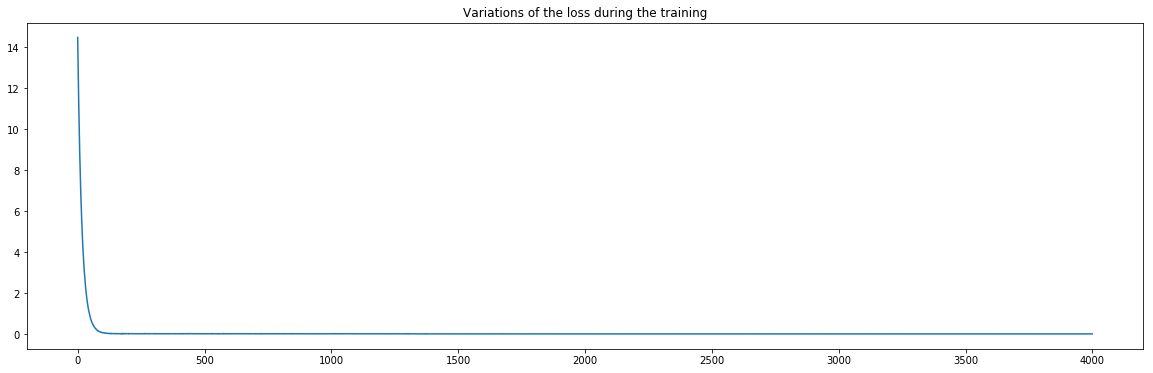

In [469]:
plt.plot(total_loss)
plt.title('Variations of the loss during the training')
plt.show()

Plot a random normalized input and its prediction

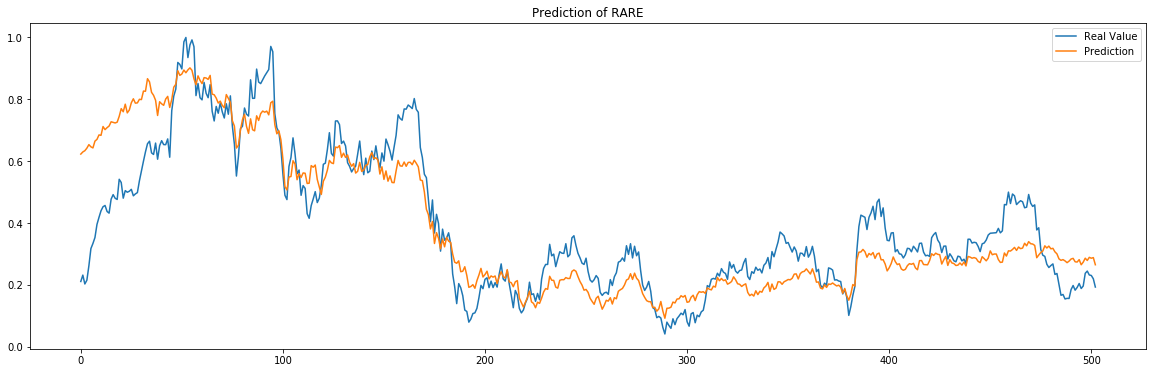

In [470]:
plot_idx = np.random.randint(low=0, high=len(X_ae))
# Real value
plt.plot(X_ae[plot_idx], label='Real Value')
# Prediction
plt.plot(predic_n[plot_idx], label='Prediction')
plt.title('Prediction of ' + str(list_tickers[plot_idx]))
plt.legend()
plt.show()

## 3.3. Finding the tickers of the best commonals

### 3.3.1. Functions

Plot the commonals function (visualization of the results)

In [471]:
def plot_commonals(pred_values, real_values, tickers):
    '''
    Warning: the pred_values, real_values and tickers must be sorted the same way!
    Create a bar plot of the MSE of the predictions over their real value.
    '''
    # Compute the array of the mean squared errors
    MSE_arr = ((pred_values - real_values)**2).mean(axis=1)
    
    MSE_df = pd.DataFrame(MSE_arr, index = tickers, columns=['MSE'])
    MSE_df = MSE_df.sort_values('MSE')
    
    MSE_df.plot.bar()
    plt.title('Commonals')
    plt.show()

Retrieve the most/least commonals

In [472]:
def return_commonals(pred_values, real_values, tickers, S): 
    '''
    Create the same dataframe than in the plot_commonals function
    Same warning about sorting the arrays the same way.
    Return a Data Frame with the MSE of the 10 most commonals and the S-10 least commonals
    '''
    MSE_arr = ((pred_values - real_values)**2).mean(axis=1)
    
    MSE_df = pd.DataFrame(MSE_arr, index = tickers, columns=['MSE'])
    MSE_df = MSE_df.sort_values('MSE')
    
    # Take 10 with lowest MSE (most commonals)
    most_c_df = MSE_df.sort_values('MSE', ascending=True).iloc[:10,:]
    # Take S-10 with highest MSE (least commonals)
    least_c_df = MSE_df.sort_values('MSE', ascending=False).iloc[:(S-10),:]
    # Join
    most_least_c_df = pd.concat([most_c_df, least_c_df]) 
    
    return(most_least_c_df)

### 3.3.2. Plot the commonals

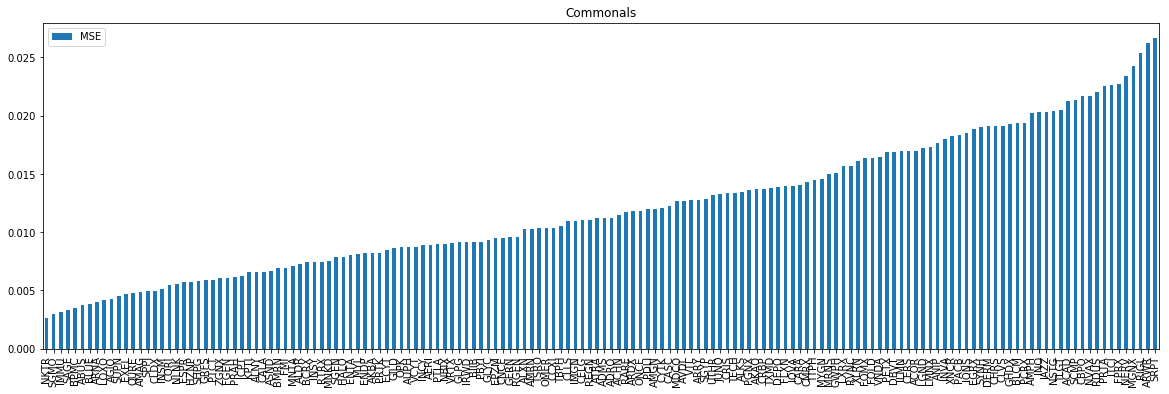

In [473]:
plot_commonals(predic_n, X_ae, list_tickers)

### 3.3.3. Extract the 10 most | S-10 least commonals

In [474]:
S = 65

most_least_c_df = return_commonals(predic_n, X_ae, list_tickers, S)

# 4. Calibration Phase

## 4.1. Import benchmark

In [481]:
# Path to the benchmark
file_benchmark = path_data + "/csv_IBB_from_2015-05-05_to_2018-01-01.csv"

if computer == 0:
    with open(file_benchmark, 'r') as csvfile:
        import_df = pd.read_csv(csvfile, index_col=None, header=0)
        benchmark = import_df['Adj Close']
        benchmark.index = import_df['Date']
        
if computer == 1:
    with open(file_benchmark, 'r', encoding ='mac_roman') as csvfile:
        import_df = pd.read_csv(csvfile, index_col=None, header=0)
        benchmark = import_df['Adj Close']
        benchmark.index = import_df['Date']

## 4.2. Functions

### 4.2.1. Operating functions

We want to match the log rate of return of the index with the log rate of returns of our 10 most | S-10 least commonals.

In [475]:
def logRateOfReturn(df, shift):
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index(ascending = True)
    
    #Be careful with the shift!
    df_shifted = df_sorted.shift(shift)
    log_rate_of_returns = np.log(df_sorted / df_shifted)
    for i in range(shift):
        log_rate_of_returns = log_rate_of_returns.drop(log_rate_of_returns.index[0])

    return log_rate_of_returns

We also want to modify the benchmark so that we set +threshold% instead of drawdown of -threshold% or less.

In [487]:
def modify_benchmark(benchmark, threshold, shift):
    '''
    We only import the Adj Close column from the benchmark, so the benchmark is a Series
    '''
    rate = logRateOfReturnWeekly(benchmark,shift)
    for i in range(len(rate)):
        if rate[i] <= - threshold:
            rate[i] = threshold
    return rate

For visualization purposes, we want to recompose the evolution of $1 invested, based on the log rate of returns that we obtain.

In [484]:
def reconstruct(rates):
    '''
    rates is an array type variable
    '''
    prices = [1]
    for i in range(len(rates)):
        prices.append( np.exp(rates[i]) * prices[i])
    return prices

### 4.2.2. Network functions

Re-use the layer function introduced in the Auto-Encoder part.

In [485]:
def layer1_calib(input_tensor, S, n_code, phase_train):
    with tf.variable_scope("calib"):
            
        with tf.variable_scope('output'):
            output, W_e = layer(input_tensor, S, n_code, phase_train, "encoder",True)
            
    return output, W_e

def layer2_calib(input_tensor, S, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('output'):
            output, W_d = layer(input_tensor, n_code, S, phase_train, "decoder",False)
            
    return tf.nn.softmax(output), W_d

### 4.2.3. Training functions

In [520]:
def next_batch_calib(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. Cut in terms of tickers
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

## 4.3. Format the data

We are going to compute the daily log returns of the benchmark, and the modified benchmark.

In [488]:
# 1 day shift
shift = 1
threshold = 0.06

benchmark_lrets = logRateOfReturn(benchmark, shift)
benchmark_lrets_mod = modify_benchmark(benchmark, threshold, shift)

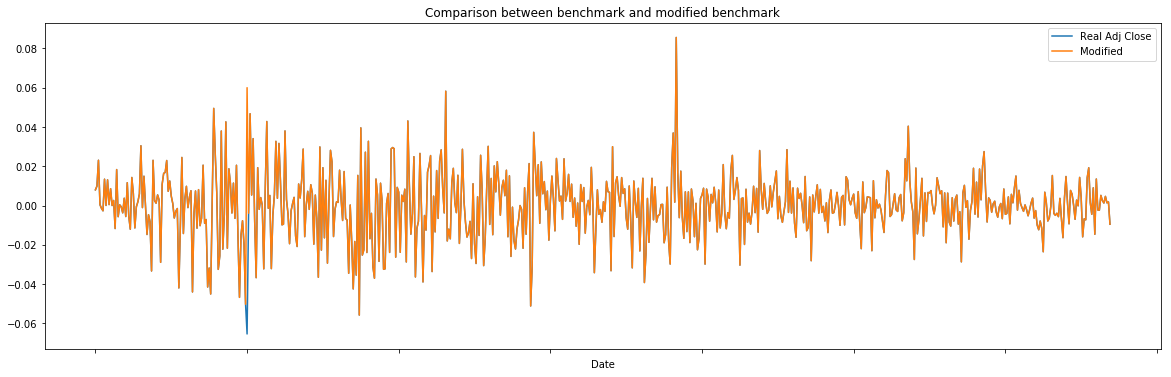

In [490]:
benchmark_lrets.plot(label='Real Adj Close')
benchmark_lrets_mod.plot(label='Modified')
plt.title('Comparison between benchmark and modified benchmark')
plt.legend()
plt.show()

Now, let's extract the dataframe of the selected portfolio

In [503]:
tickers_ptfolio = most_least_c_df.index
DF_most_least_c = DF_adj_close.loc[:,tickers_ptfolio]
DF_ptfolio_lrets = logRateOfReturn(DF_most_least_c, shift)

## 4.4. Train

### 4.4.1. Set the parameters

In [532]:
learning_rate_calib = 0.0004
num_steps_calib = 2000
batch_size_calib = 25
lambd_calib = 0.2
val_dropout_calib = 0.88

display_step_calib = 1000

cross_len_calib = 1


# Network Parameters 

num_input_calib = S
n_hidden_calib = 5  # bottleneck layer
num_output_calib = S

### 4.4.2. Format the input/output data

Again, we extract only the values of the lrets in the same orders to retrieve the tickers easily. The train is composed by the 503 first days, the test on the remaining)

In [513]:
X_c_train = DF_ptfolio_lrets.iloc[range(503),:].values
X_c_test = DF_ptfolio_lrets.iloc[np.arange(503,670),:].values
Y_c_train = benchmark_lrets_mod[:503].values
Y_c_test = benchmark_lrets_mod[503:].values

In [526]:
np.shape(Y_c_train)

(503,)

### 4.4.3. Run the training

In [533]:
with tf.Graph().as_default():
    with tf.variable_scope("calibration_phase"):
        
        # Placeholders
        x = tf.placeholder("float", [None, S])
        label = tf.placeholder("float", [None, 1])
        
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout

        # Extract the latent information (logits from the bottleneck layer)
        hidden, W_e = layer1_calib(x, S, n_hidden_calib, phase_train)

        # Extract the outputs of the autoencoder
        output, W_d = layer2_calib(hidden, S, n_hidden_calib, phase_train)
        
        rr_tot = np.dot(output, x)
            
        cost = loss(mse(rr_tot, label), regularizer(W_e, W_d), lambd_calib, num_input_calib, batch_size_calib)

        train_op = training(cost, learning_rate_calib)

        eval_op, val_summary_op = evaluate(rr_tot, label)

        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()

        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        

        # Create the session list that will be runned for training
        
        total_loss = np.zeros(num_steps_calib)
        
        start_time = time()
        
        session = tf.Session()
        
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        for i in range(1, num_steps_calib + 1):
            
            total_batch = int(len(X_c_train) / batch_size_calib)

            for j in range(total_batch):
                mini_batch_x, mini_batch_y = next_batch_calib(batch_size_calib, X_c_train, Y_c_train)

                _, loss_batch, summary = session.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x , label: mini_batch_y.reshape((batch_size_calib,1)), 
                                       phase_train: True, keep_prob: val_dropout_calib})
            
            
            total_loss[i-1] = loss_batch
            
            summary_writer.add_summary(summary, i)
            
            if i % display_step == 0:

                    print('Step %i : Minibatch Loss: %f' % (i, loss_batch))
                    curr_time = time()
                    elapsed_time = curr_time-start_time
                    print('Estimated remaining time = ', elapsed_time / i * (num_steps_calib-i),'s\n')
                    
        
        #mini_batch_x, mini_batch_y = next_batch(batch_size, stock_list_2, y)
        
        '''
        lll=[]
        for i in y_valid:
            lll.append([i])
        mini_batch_x, mini_batch_y = stock_list_2, lll
        '''
        
        predi_calib = session.run(output , feed_dict={x: X_c_test , label: Y_c_test.reshape((len(Y_c_test),1)), phase_train: False, keep_prob: 1})

Step 100 : Minibatch Loss: 0.203820
Estimated remaining time =  184.91251850128174 s

Step 200 : Minibatch Loss: 0.005726
Estimated remaining time =  150.55322241783142 s

Step 300 : Minibatch Loss: 0.000148
Estimated remaining time =  137.2952582836151 s

Step 400 : Minibatch Loss: 0.000221
Estimated remaining time =  127.51536750793457 s

Step 500 : Minibatch Loss: 0.000274
Estimated remaining time =  118.22510647773743 s

Step 600 : Minibatch Loss: 0.000118
Estimated remaining time =  107.8353664080302 s

Step 700 : Minibatch Loss: 0.000128
Estimated remaining time =  98.02379587718418 s

Step 800 : Minibatch Loss: 0.000066
Estimated remaining time =  88.98398530483246 s

Step 900 : Minibatch Loss: 0.000061
Estimated remaining time =  80.49171884854634 s

Step 1000 : Minibatch Loss: 0.000183
Estimated remaining time =  72.39919090270996 s

Step 1100 : Minibatch Loss: 0.000200
Estimated remaining time =  64.58758605610241 s

Step 1200 : Minibatch Loss: 0.000085
Estimated remaining ti

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


### 4.4.4 Analyse the performances

Plot the loss of the training

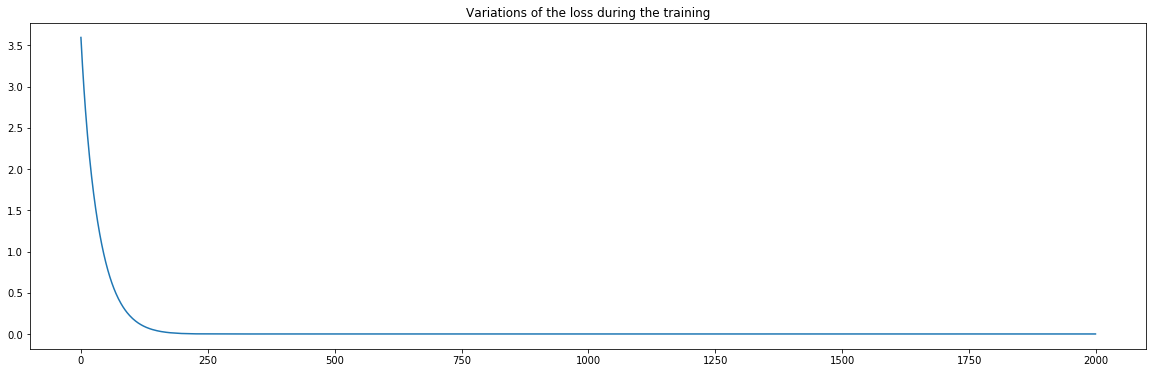

In [534]:
plt.plot(total_loss)
plt.title('Variations of the loss during the training')
plt.show()

Plot all the reconstructed curves

In [557]:
# Take the weight
weights_ptfolio = predi_calib[0]

# Cumulate the returns of the portfolio over the period of time in test
ptfolio_lrets = np.dot(X_c_test, weights_ptfolio)
real_benchmark_lrets_test = benchmark_lrets[503:].values

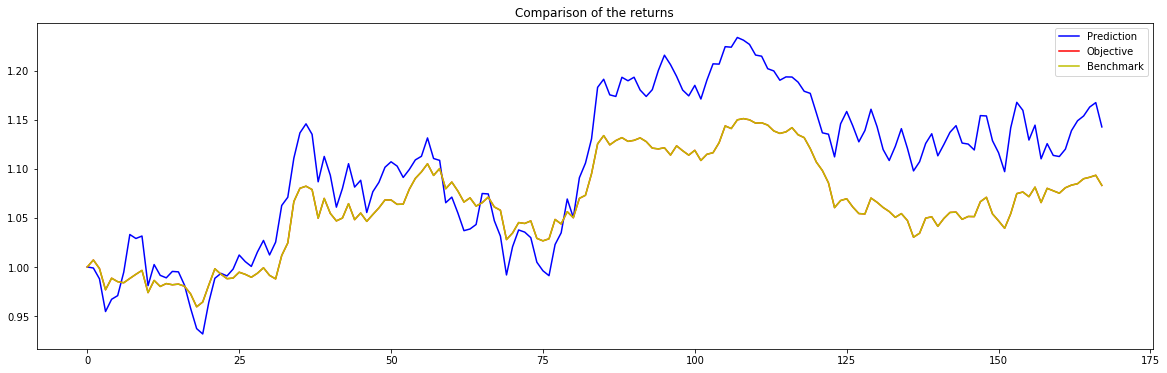

In [558]:
portfolio_returns = reconstruct(ptfolio_lrets)
calib_returns = reconstruct(Y_c_test)
real_returns = reconstruct(real_benchmark_lrets_test)
plt.plot(portfolio_returns,'b', label = "Prediction")
plt.plot(calib_returns,'r', label = "Objective")
plt.plot(real_returns,'y', label = "Benchmark")
plt.title('Comparison of the returns')
plt.legend()
plt.show()